# Setup

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet
!pip install ipympl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00


In [ ]:
# @title Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA


In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True


In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# Stringer dataset

Text(0, 0.5, 'pupil diameter')

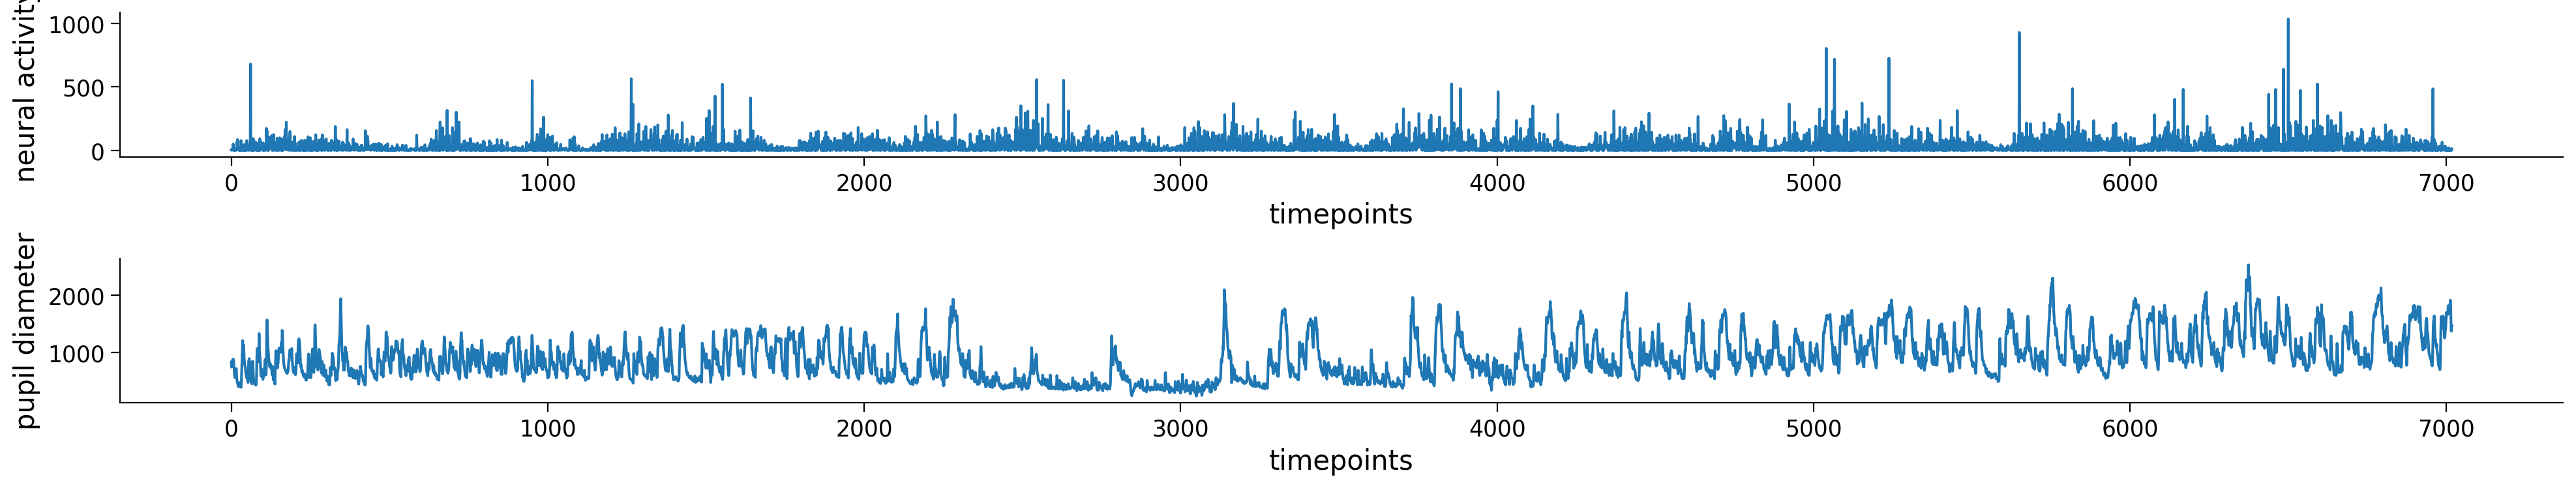

In [ ]:
# @title Data structure

neural = dat['sresp']    # neural activity, neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
pupil = dat['pupilArea'] # pupil diameter

plt.subplot(2,1,1)
plt.plot(dat['sresp'][:7018, 0])
plt.xlabel('timepoints')
plt.ylabel('neural activity')

plt.subplot(2,1,2)
plt.plot(dat['pupilArea'][:, 0])
plt.xlabel('timepoints')
plt.ylabel('pupil diameter')


# GLM - Polina’s notebook - pupil diameter
- input: neural activity
- output: pupil diameter

In [ ]:
x = dat['sresp'].T
y = dat['pupilArea']

print(x.shape)
print(y.shape)

def calculate_predicted_spike_counts(x,y):
  constant = np.ones_like(y)
  # Calculating theta
  theta = np.linalg.inv(x.T @ x) @ x.T @ y
  theta_lg = theta[1:]
  # Calculation predictions yhat
  yhat = x @ theta
  return yhat

predicted_spikes = calculate_predicted_spike_counts(x,y)
print(predicted_spikes.shape)
print(predicted_spikes)

(7018, 11983)
(7018, 1)
(7018, 1)
[[ -37818.62701927]
 [-253942.82481273]
 [  55542.13982674]
 ...
 [ -91682.9985953 ]
 [-231539.88920886]
 [  46321.73339223]]


Text(0.5, 1.0, 'Visual estimation of goodness-of-prediction of the linear model')

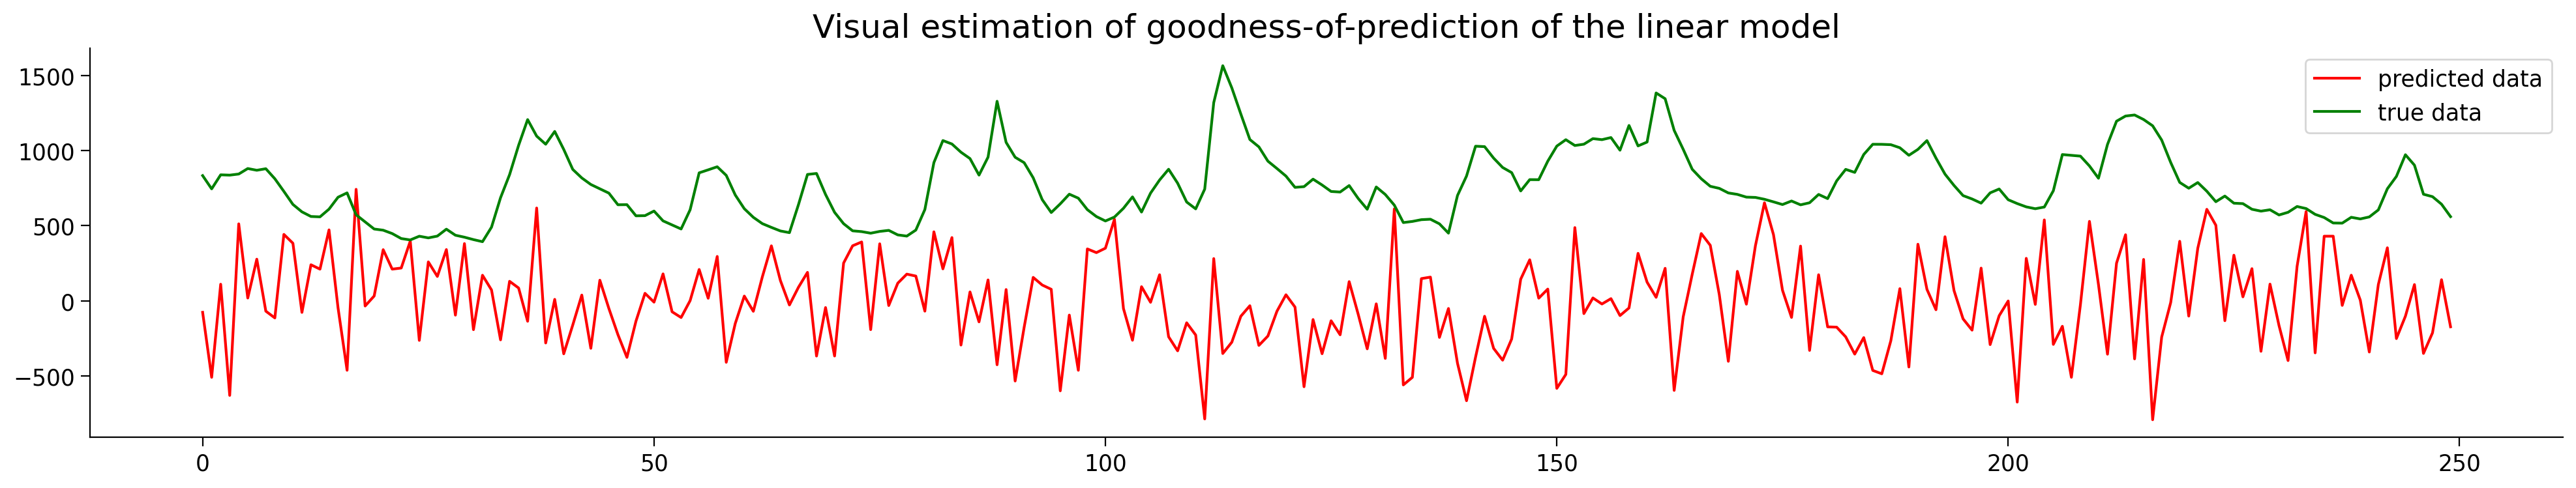

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(predicted_spikes[:250]/500, c='red', label='predicted data')
plt.plot(dat['pupilArea'][:250], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model')

# GLM - Tristan’s notebook - running speed
- input: neural activity
- output: running speed

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
pupil = zscore(dat['pupilArea'], axis=0, nan_policy='omit')
eye_pos = dat['pupilCOM']
locomotion = zscore(dat['run'], axis=0, nan_policy='omit')
face_svd = zscore(dat['beh_svd_time'], axis=0, nan_policy='omit')

In [ ]:
def normalize_data(data: np.array, new_min: int, new_max: int, axis=None):
    if axis is None:
        # Perform normalization across the entire array
        return ((data - np.min(data)) * (new_max - new_min) / (np.max(data) - np.min(data))) + new_min
    else:
        # Perform normalization along the specified axis
        min_vals = np.min(data, axis=axis, keepdims=True)
        max_vals = np.max(data, axis=axis, keepdims=True)
        return ((data - min_vals) * (new_max - new_min) / (max_vals - min_vals)) + new_min

# Build the full design matrix
# Predict pupil diameter: y = pupil
y = locomotion
y = normalize_data(y, new_min=0, new_max=1)

# solve: yhat = x theta, theta =X.T y / X.T X
x = neuron_response = dat['sresp']

# Normalize, center to the mean and scale from 0 to 1
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

constant = np.ones((1, x.shape[1])) # accounts for offset
X = np.concatenate([constant, x], axis=0).T

In [ ]:
print(X.shape)
print(y.shape)

(7018, 11984)
(7018, 1)


In [ ]:
# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y

# Compute predicted spike counts
yhat_np = X @ theta

Text(0.5, 1.0, 'Visual estimation of goodness-of-prediction of the linear model')

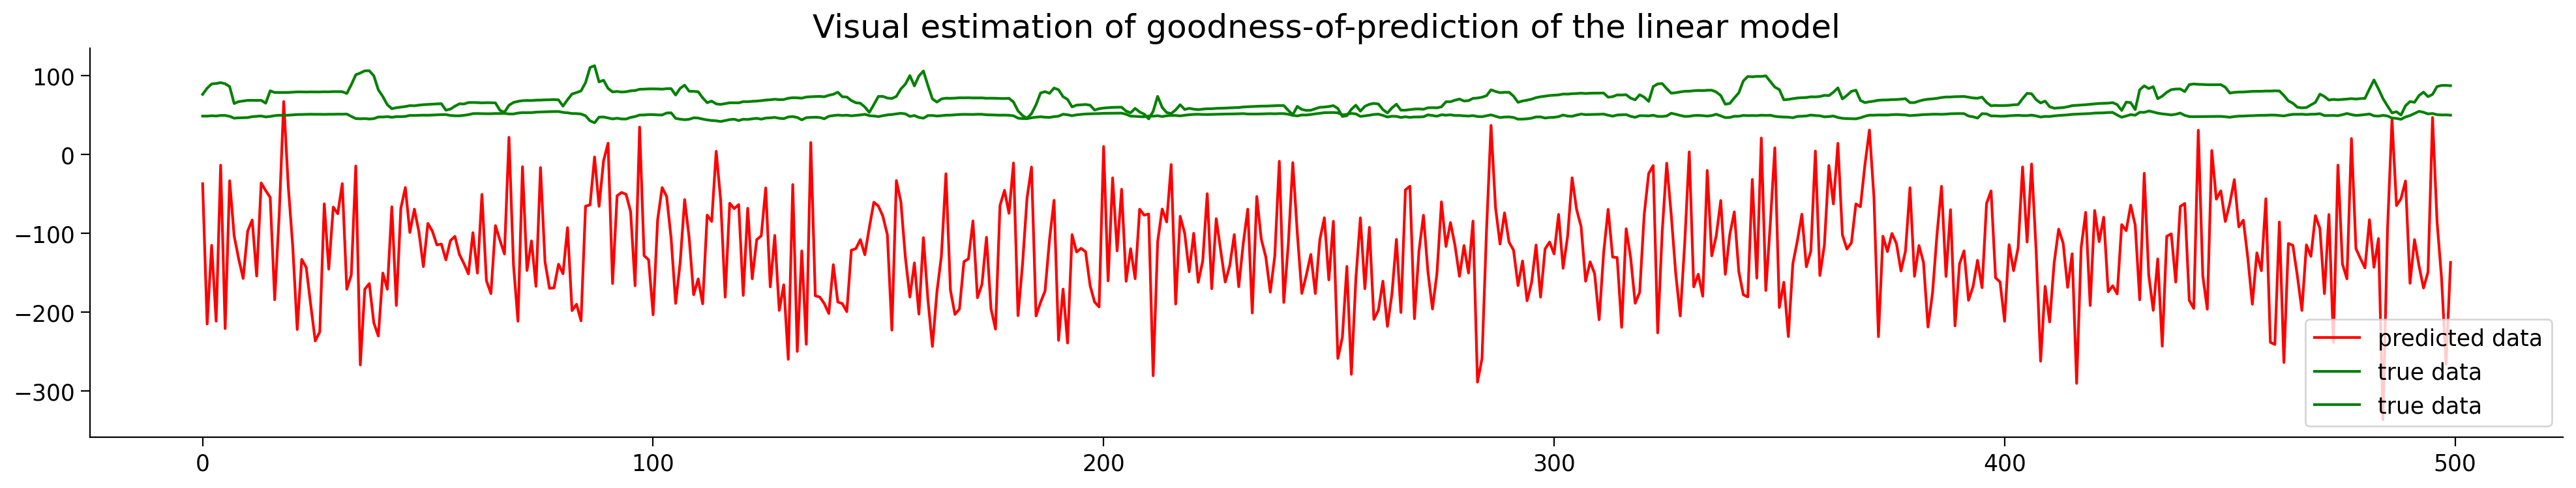

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(yhat_np[:500], c='red', label='predicted data')
plt.plot(y[:500], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model')

Text(0.5, 1.0, 'Visual estimation of goodness-of-prediction of the linear model')

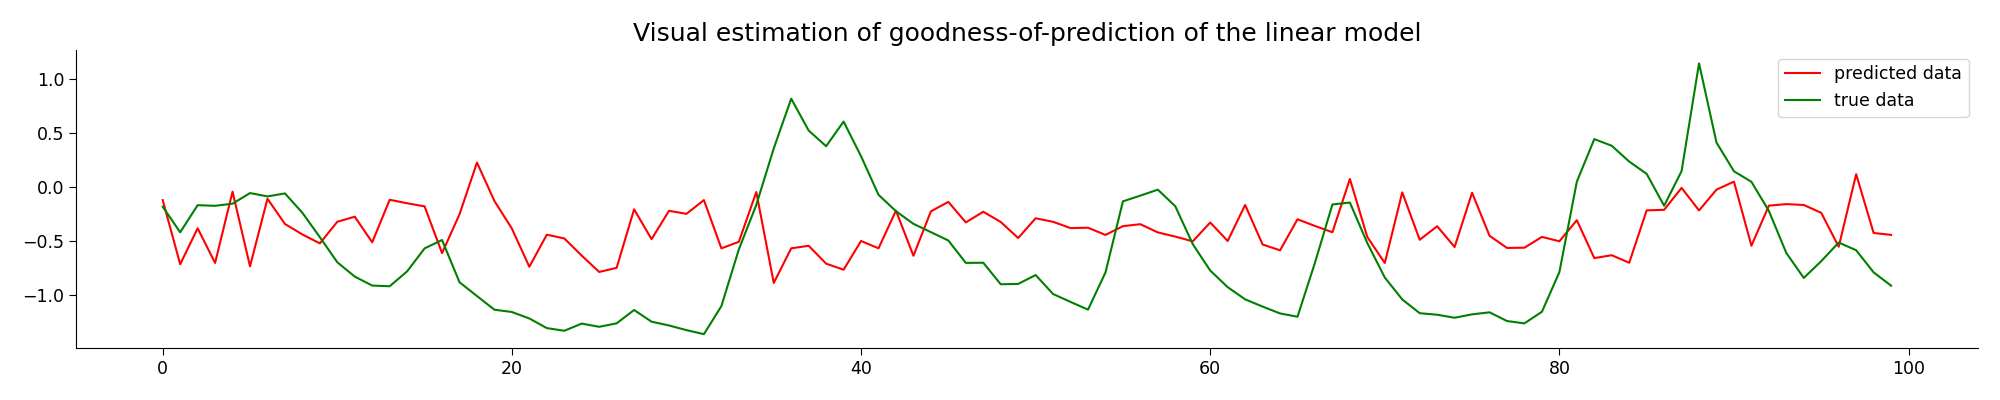

In [ ]:
%matplotlib widget
plt.figure()
plt.plot(yhat_np[:100]/300, c='red', label='predicted data')
plt.plot(pupil[:100], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model')


## GLM using the sklearn toolbox

In [ ]:
from sklearn.linear_model import LinearRegression

# assuming y is a 2D array with shape (n_samples, 1)
# and x is a 2D array with shape (n_samples, n_features)
y = np.squeeze(locomotion)
y = zscore(y)
y = normalize_data(y, new_min=0, new_max=1)


x = dat['sresp'].T
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

# Initialize the model
model = LinearRegression() # https://scikit-learn.org/stable/modules/linear_model.html

# Fit the model
model.fit(x, y)

# Now, you can predict new data using:
yhat = model.predict(x)

In [ ]:
print(x.shape)
print(y.shape)
print(model.coef_.shape)

(7018, 11983)
(7018,)
(11983,)


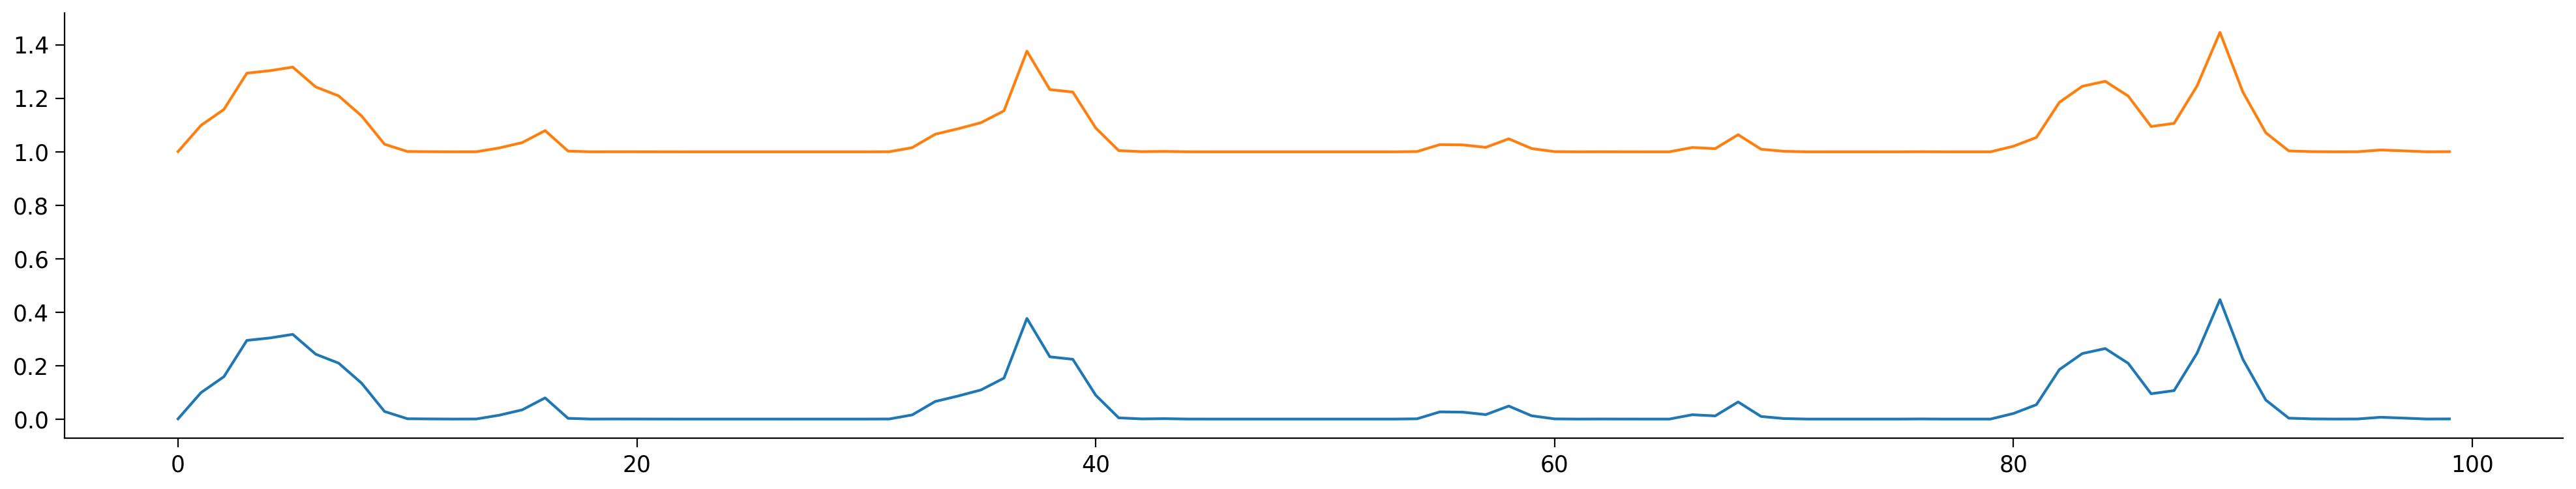

In [ ]:
plt.figure()
plt.plot(yhat[:100])
plt.plot(y[:100] +1)

In [ ]:
# Re-try the OLS Regression, but use the train-test split from Stringer2019
timepoints, no_neurons = x.shape
X_1_train = x[:timepoints//2, :no_neurons//2]
X_1_test = x[timepoints//2:, :no_neurons//2]
X_2_train = x[:timepoints//2, no_neurons//2:]
X_2_test = x[timepoints//2:, no_neurons//2:]
y_train = y[:timepoints//2]
y_test = y[timepoints//2:]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_1_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_1_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Coefficients: 
 [-0.02735293 -0.04177499 -0.00825677 ...  0.01907938  0.16956283
 -0.01179032]
Mean squared error: 0.02
Coefficient of determination: 0.45


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(regr, x, y, cv=8)  # k=8 cross validation
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies.mean(), accuracies.std()))

0.33 accuracy with a standard deviation of 0.40


Text(0.5, 1.0, 'Model predicition of held-out test data')

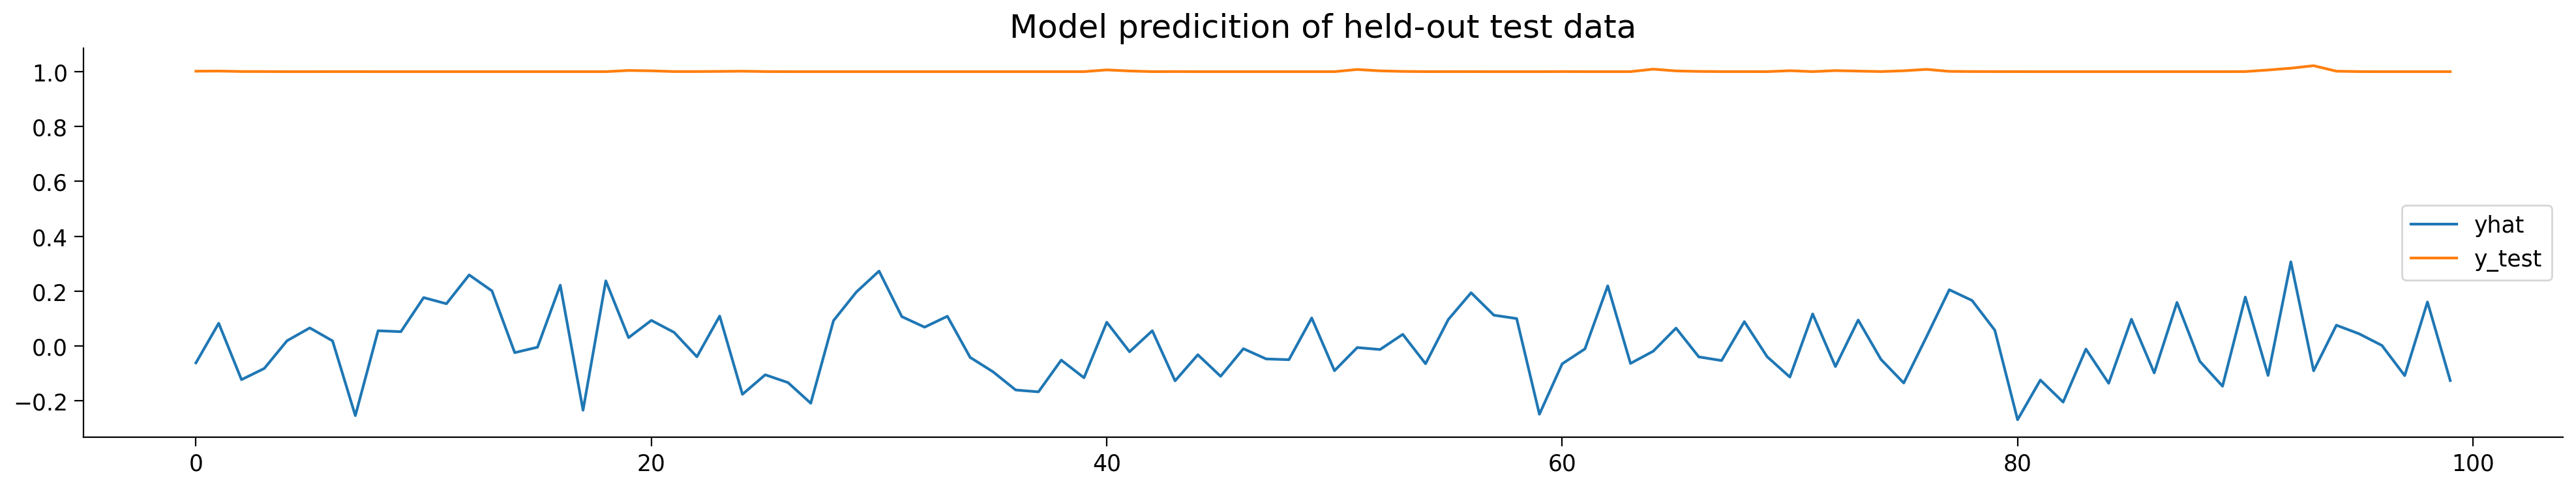

In [ ]:
plt.figure()
plt.plot(y_pred[:100], label='yhat')
plt.plot(y_test[:100] +1, label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

## L1 Regularization

Text(0.5, 1.0, 'Model predicition of held-out test data')

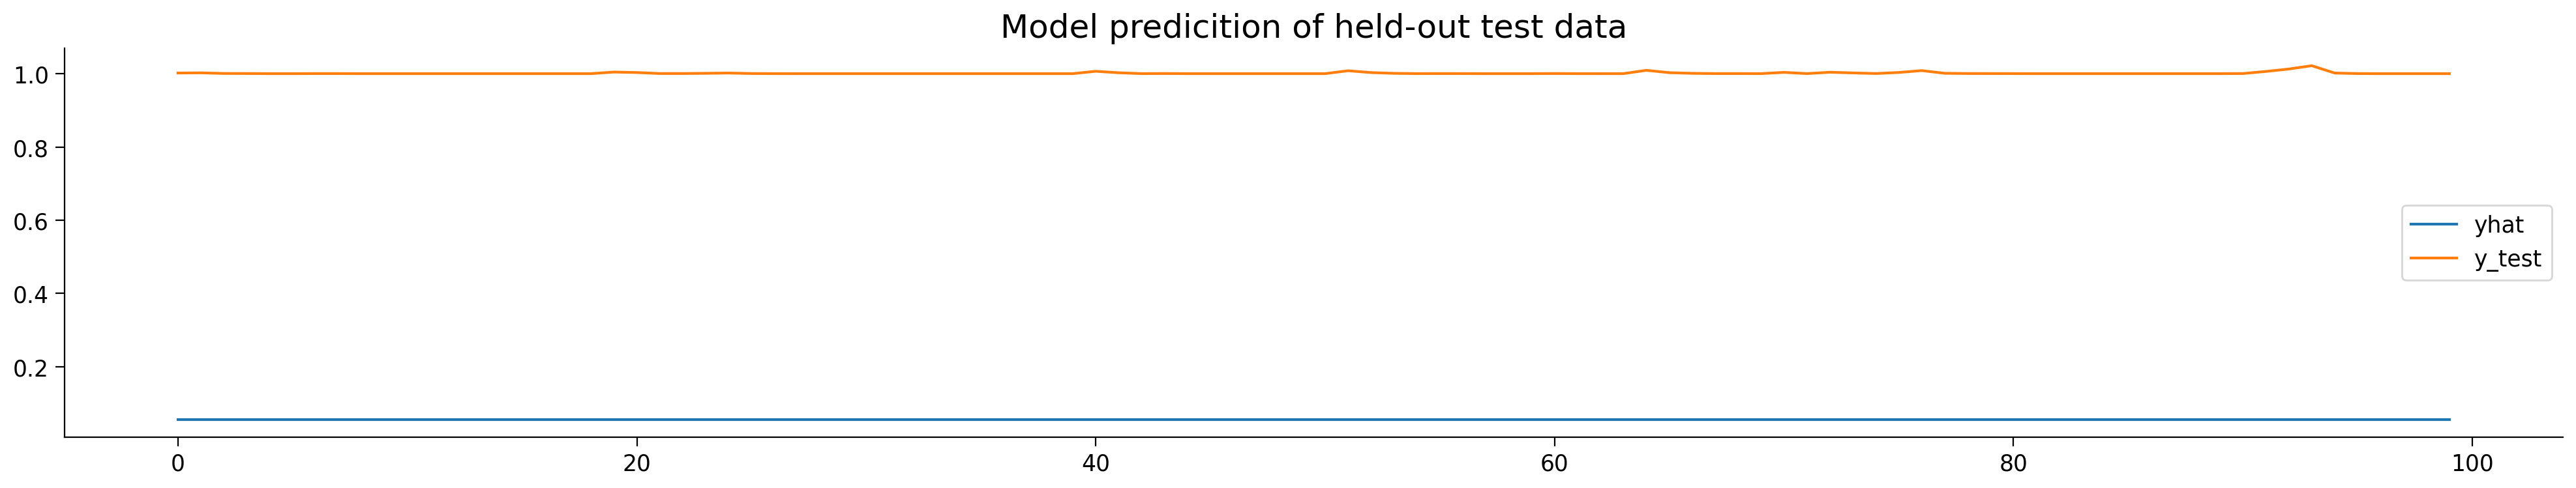

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=False)

reg_l1 = Lasso(alpha=0.1)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)


plt.figure()
plt.plot(y_pred_l1[:100], label='yhat')
plt.plot(y_test[:100] +1, label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

In [ ]:
from time import time
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# This is Chat GPT's suggestion on how to implement a good cross-validation scheme for time series data
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

t0 = time()
#lasso_cv takes a cross-validation scheme as a parameter
lasso_cv = LassoCV(cv=tscv).fit(X_train, y_train)
print(f"LassoCV fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso_cv.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"LassoCV r^2 on test data : {r2_score_lasso:.3f}")
print(f"Optimal alpha : {lasso_cv.alpha_}")


LassoCV fit done in 437.925s
LassoCV r^2 on test data : 0.819
Optimal alpha : 5.723958988733032e-05


Text(0.5, 1.0, 'Model predicition of held-out test data')

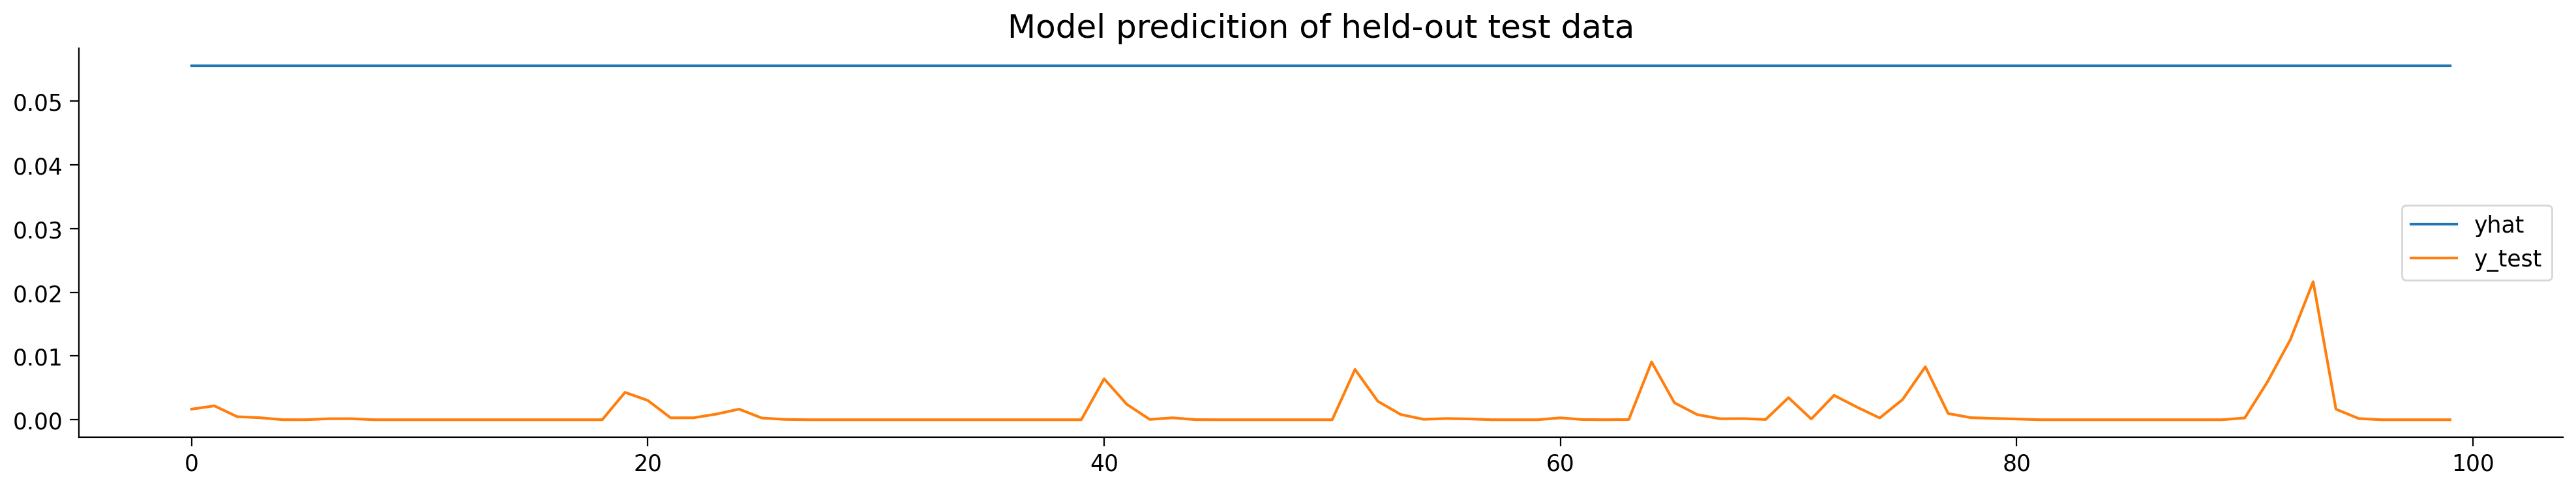

In [ ]:
reg_l1 = Lasso(alpha=10) # (alpha=lasso_cv.alpha_)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)


plt.figure()
plt.plot(y_pred_l1[:100], label='yhat')
plt.plot(y_test[:100], label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

In [ ]:
accuracies = cross_val_score(reg_l1, X_train, y_train, cv=tscv)
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies.mean(), accuracies.std()))

-59.48 accuracy with a standard deviation of 118.88


# GLM - Tristan’s notebook - pupil position
- input: neural activity
- output: pupil position

In [ ]:
pupil = zscore(dat['pupilArea'], axis=0, nan_policy='omit')
eye_pos = dat['pupilCOM']
locomotion = zscore(dat['run'], axis=0, nan_policy='omit')
face_svd = zscore(dat['beh_svd_time'], axis=0, nan_policy='omit')

#print(np.any(np.isnan(eye_pos)))

In [ ]:
def normalize_data(data: np.array, new_min: int, new_max: int, axis=None):
    if axis is None:
        # Perform normalization across the entire array
        return ((data - np.min(data)) * (new_max - new_min) / (np.max(data) - np.min(data))) + new_min
    else:
        # Perform normalization along the specified axis
        min_vals = np.min(data, axis=axis, keepdims=True)
        max_vals = np.max(data, axis=axis, keepdims=True)
        return ((data - min_vals) * (new_max - new_min) / (max_vals - min_vals)) + new_min

# Build the full design matrix
# Predict pupil diameter: y = pupil position

eye_pos = np.nan_to_num(eye_pos, nan=0.0)
y = eye_pos
y_z1 = zscore(y[:,0], axis=0, nan_policy='omit')
y_z2 = zscore(y[:,1], axis=0, nan_policy='omit')

y_x = normalize_data(y_z1, new_min=0, new_max=1)
y_y = normalize_data(y_z2, new_min=0, new_max=1)

# solve: yhat = x theta, theta =X.T y / X.T X
x = neuron_response = dat['sresp']

# Normalize, center to the mean and scale from 0 to 1
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

constant = np.ones((1, x.shape[1])) # accounts for offset
X = np.concatenate([constant, x], axis=0).T


In [ ]:
print(y_x[:50])
print(y_y[:50])

#plt.plot(eye_pos[:50,0],'yellow')
plt.plot(y_x[:50],'blue',label='pupil position X')
plt.plot(y_y[:50],'red',label='pupil position Y')
plt.legend()

[0.67685111 0.74612387 0.79431271 0.79933748 0.8089772  0.79645542
 0.76441411 0.57356927 0.59489682 0.60185508 0.60894787 0.60948607
 0.60805394 0.60975422 0.57710511 0.71669936 0.69816785 0.69825978
 0.69760899 0.69845386 0.70147894 0.7046492  0.70440889 0.70313452
 0.70467998 0.70420246 0.70372803 0.70597463 0.7049524  0.70813839
 0.70759064 0.70686154 0.68660086 0.78511299 0.89743919 0.91779933
 0.94214942 0.9426175  0.88653274 0.72846924 0.65241533 0.55990859
 0.51486032 0.52635755 0.53305965 0.53951299 0.54979792 0.54777357
 0.555198   0.56035517]
[0.75842009 0.75837716 0.76515844 0.76082214 0.7715756  0.77170845
 0.75426248 0.71782837 0.72429116 0.72619695 0.72919105 0.74732894
 0.75510165 0.76097412 0.74236711 0.75259908 0.7669207  0.77551296
 0.77466723 0.77696386 0.78355812 0.78928231 0.79171337 0.79427781
 0.79564421 0.79424908 0.7943907  0.79270548 0.79549124 0.79523999
 0.79769975 0.79622859 0.79927454 0.75263779 0.70944165 0.70518081
 0.70963797 0.70121777 0.70864975 0.74

In [ ]:
# Get the MLE weights for the LG model
theta1 = np.linalg.inv(X.T @ X) @ X.T @ y_x
theta2 = np.linalg.inv(X.T @ X) @ X.T @ y_y

# Compute predicted spike counts
yhat_np1 = X @ theta1
yhat_np2 = X @ theta2

In [ ]:
print(theta1)
print(yhat_np1)

[-85512.09070202   5592.21648221  48914.82937775 ...   4452.91876075
   -640.46328003   3101.39267438]
[  -37.65359525 -2161.337765   -1432.88356887 ... -1258.28195641
 -1441.30261442  -362.1253175 ]


In [ ]:
%matplotlib inline
plt.subplot(2,1,1)
plt.plot(yhat_np1[:500], c='red', label='predicted data')
plt.plot(y_x[:500], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model - pupil position x')

plt.subplot(2,1,2)
plt.plot(yhat_np2[:500], c='red', label='predicted data')
plt.plot(y_y[:500], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model - pupil position y')

<ipython-input-23-be68bff65e99>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


Text(0.5, 1.0, 'Visual estimation of goodness-of-prediction of the linear model - pupil position y')

Text(0.5, 1.0, 'Visual estimation of goodness-of-prediction of the linear model - pupil position y')

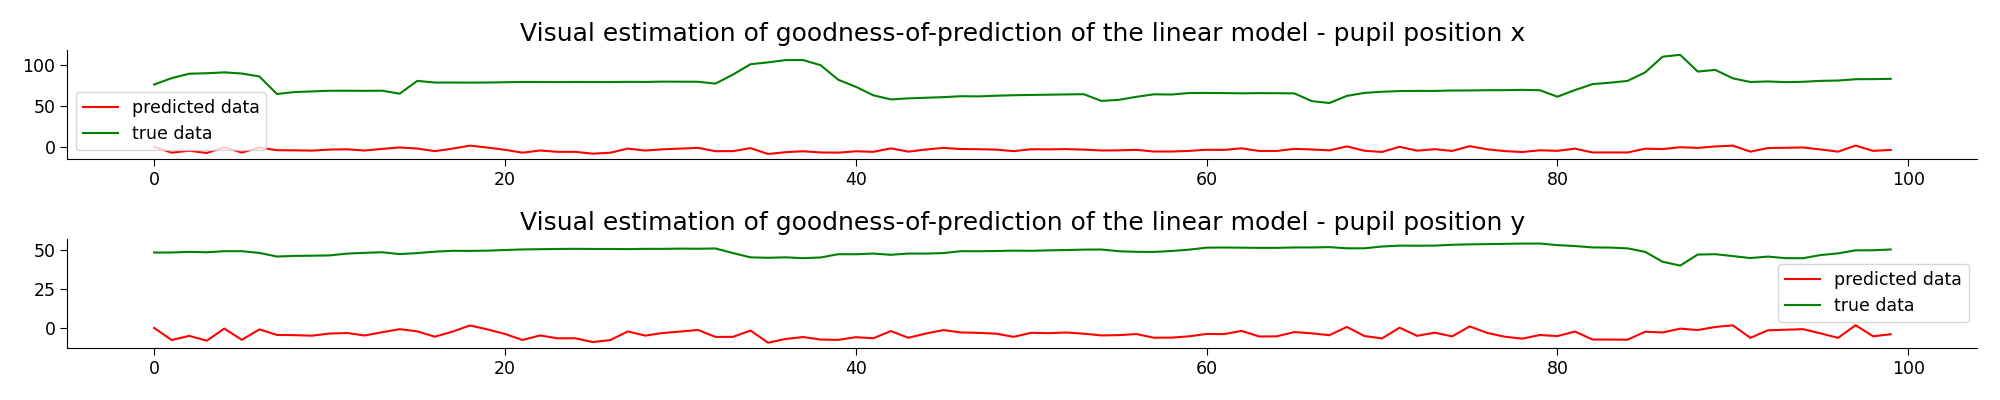

In [ ]:

%matplotlib widget
plt.figure()
plt.subplot(2,1,1)
plt.plot(yhat_np1[:100]/300, c='red', label='predicted data')
plt.plot(eye_pos[:100,0], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model - pupil position x')

plt.subplot(2,1,2)
plt.plot(yhat_np2[:100]/300, c='red', label='predicted data')
plt.plot(eye_pos[:100,1], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model - pupil position y')


## GLM using the sklearn toolbox

In [ ]:
from sklearn.linear_model import LinearRegression

# assuming y is a 2D array with shape (n_samples, 1)
# and x is a 2D array with shape (n_samples, n_features)

eye_pos = np.nan_to_num(eye_pos, nan=0.0)
yx = np.squeeze(eye_pos[:,0])
yx = zscore(yx)
yx = normalize_data(yx, new_min=0, new_max=1)

yy = np.squeeze(eye_pos[:,1])
yy = zscore(yy)
yy = normalize_data(yy, new_min=0, new_max=1)

x = dat['sresp'].T
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

# Initialize the model
model = LinearRegression() # https://scikit-learn.org/stable/modules/linear_model.html

# Fit the model
model.fit(x, yx)
model.fit(x, yy)

# Now, you can predict new data using:
yhat = model.predict(x)

In [ ]:
print(x.shape)
print(y.shape)
print(model.coef_.shape)

(7018, 11983)
(7018,)
(11983,)


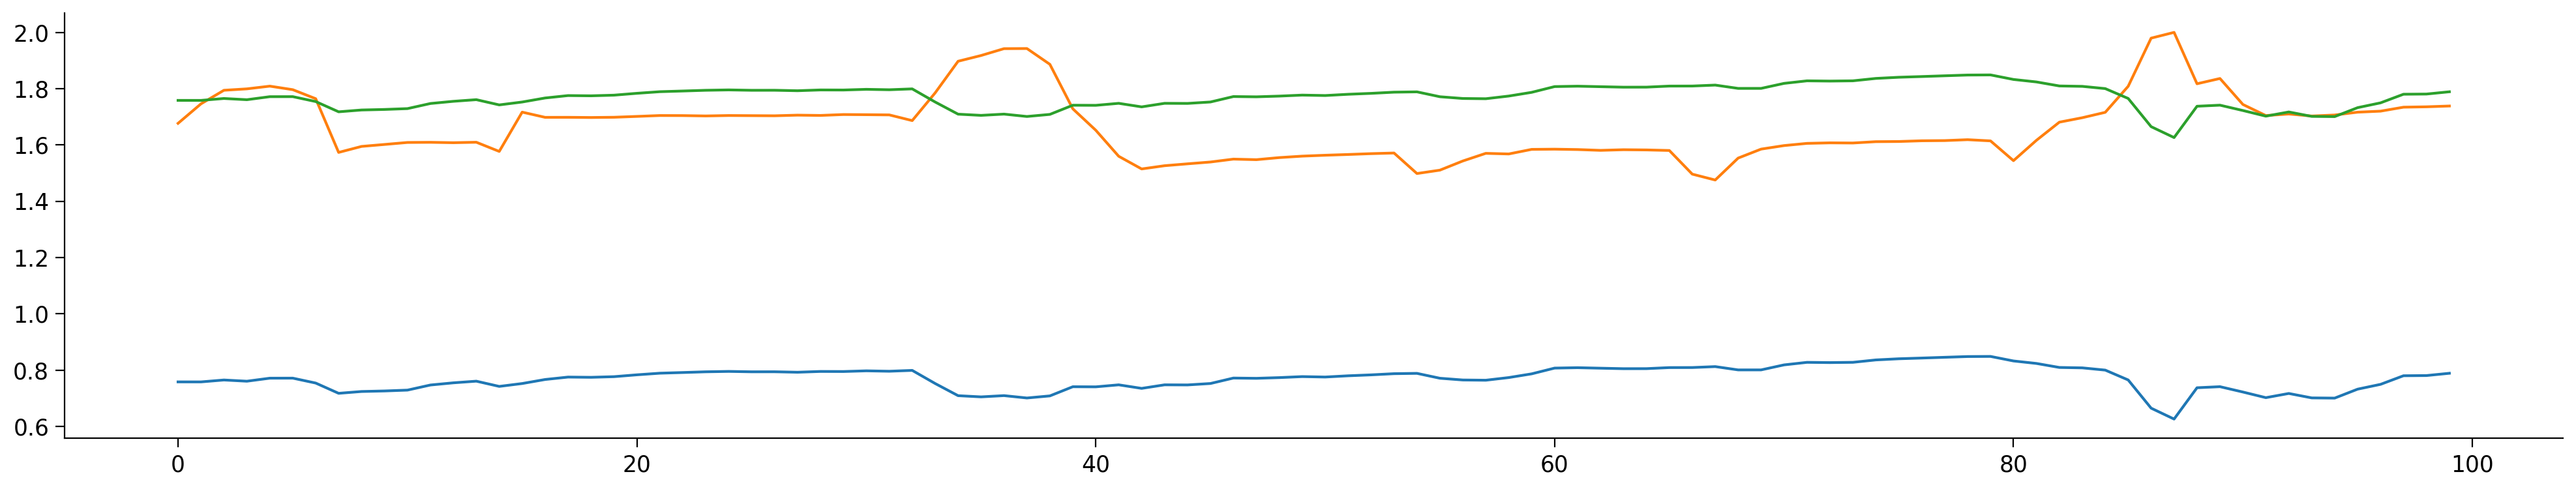

In [ ]:
plt.figure()
plt.plot(yhat[:100])
plt.plot(yx[:100] +1)
plt.plot(yy[:100] +1)


In [ ]:
# Re-try the OLS Regression, but use the train-test split from Stringer2019
timepoints, no_neurons = x.shape
X_1_train = x[:timepoints//2, :no_neurons//2]
X_1_test = x[timepoints//2:, :no_neurons//2]
X_2_train = x[:timepoints//2, no_neurons//2:]
X_2_test = x[timepoints//2:, no_neurons//2:]
yx_train = yx[:timepoints//2]
yx_test = yx[timepoints//2:]
yy_train = yy[:timepoints//2]
yy_test = yy[timepoints//2:]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_1_train, yx_train)
regr.fit(X_1_train, yy_train)

# Make predictions using the testing set
yx_pred = regr.predict(X_1_test)
yy_pred = regr.predict(X_1_test)

'''
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
'''

'\n# The coefficients\nprint("Coefficients: \n", regr.coef_)\n# The mean squared error\nprint("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))\n# The coefficient of determination: 1 is perfect prediction\nprint("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))\n'

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies_x = cross_val_score(regr, x, yx, cv=8)  # k=8 cross validation
accuracies_y = cross_val_score(regr, x, y, cv=8)  # k=8 cross validation
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies_x.mean(), accuracies_x.std()))
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies_y.mean(), accuracies_y.std()))

0.23 accuracy with a standard deviation of 0.13
0.33 accuracy with a standard deviation of 0.40


In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(yx_pred[:100], label='yhat')
plt.plot(yx_test[:100] +1, label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

plt.subplot(2,1,2)
plt.plot(yy_pred[:100], label='yhat')
plt.plot(yy_test[:100] +1, label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')


## L1 Regularization

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=False)

reg_l1 = Lasso(alpha=0.1)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)


plt.figure()
plt.plot(y_pred_l1[:100], label='yhat')
plt.plot(y_test[:100] +1, label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

In [ ]:
from time import time
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# This is Chat GPT's suggestion on how to implement a good cross-validation scheme for time series data
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

t0 = time()
#lasso_cv takes a cross-validation scheme as a parameter
lasso_cv = LassoCV(cv=tscv).fit(X_train, y_train)
print(f"LassoCV fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso_cv.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"LassoCV r^2 on test data : {r2_score_lasso:.3f}")
print(f"Optimal alpha : {lasso_cv.alpha_}")


In [ ]:
reg_l1 = Lasso(alpha=lasso_cv.alpha_)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)


plt.figure()
plt.plot(y_pred_l1[:100], label='yhat')
plt.plot(y_test[:100], label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

In [ ]:
accuracies = cross_val_score(reg_l1, X_train, y_train, cv=tscv)
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies.mean(), accuracies.std()))